# Multy-dimensional

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

EPS = 0.001
MAX_ITER = 1000

In [2]:
import random
import scipy

K = 1000

## Generate values

In [3]:
def f(x):
    return 1 / (x**2 - 3 * x + 2)

def generate_values():
    values = np.random.normal(0, 1, K)
    x_values = np.arange(0, stop=K , step=1) * 3 / 1000
    for index, k in enumerate(range(0, K)):
        f_x = f(x_values[index])
        if f_x < -100:
            values[index] -= 100
            continue
        if f_x > 100:
            values[index] += 100
            continue
        values[index] += f_x
    return values, x_values

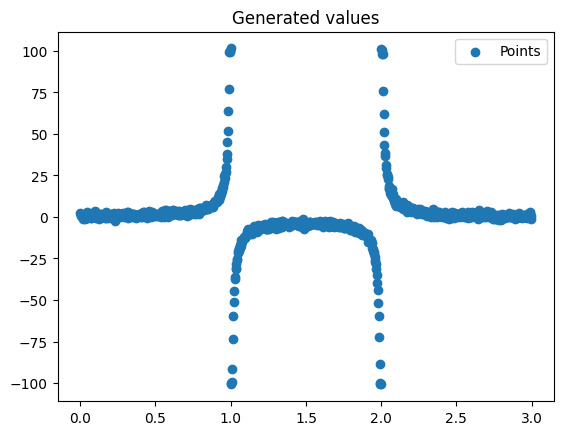

In [4]:
values, x_points = generate_values()

plt.scatter(x_points, values, label='Points')
plt.title("Generated values")
plt.legend()
plt.savefig('./figures/generated_values.png')
plt.show()

## Algorithms

In [5]:
def neldermead_search(loss_function, args):
    return scipy.optimize.minimize(
        loss_function,
        x0=[1, 1, 1, 1],
        bounds=[(-5, 5), (-5, 5), (-5, 5), (-5, 5)],
        method='Nelder-Mead',
        args=args,
        options={'maxiter': 1000}
    )

def levenberg_marquardt(loss_function, args):
    return scipy.optimize.least_squares(
        loss_function,
        x0=np.array([1, 1, 1, 1]),
        max_nfev=1000,
        args=args
    )

def differential_evolution(loss_function, args):
    return scipy.optimize.differential_evolution(
        loss_function,
        bounds=[(-5, 5), (-5, 5), (-5, 5), (-5, 5)],
        args=args,
        maxiter=1000
    )

def  simulated_annealing(loss_function, args):
    return scipy.optimize.dual_annealing(
        loss_function,
        bounds=[(-5, 5), (-5, 5), (-5, 5), (-5, 5)],
        maxiter=1000,
        args=args
    )

In [6]:
def rational(x, a, b, c, d):
    return (a * x + b) / (x**2 + c* x + d)

In [7]:
def loss(point, func, x_points=x_points, y_points=values):
    return np.sum((func(x_points, point[0], point[1], point[2], point[3]) - y_points) ** 2)

## Comparison

In [8]:
nelder_points = neldermead_search(loss, (rational, ))
levenberg_points = levenberg_marquardt(loss, (rational, ))
differential_points = differential_evolution(loss, (rational, ))
annealing_points = simulated_annealing(loss, (rational, ))

In [22]:
results = {
    "Neldermead": neldermead_search(loss, (rational, )),
    "Levenberg": levenberg_marquardt(loss, (rational, )),
    "Differential": differential_evolution(loss, (rational, )),
    "Annealing": simulated_annealing(loss, (rational, ))
}

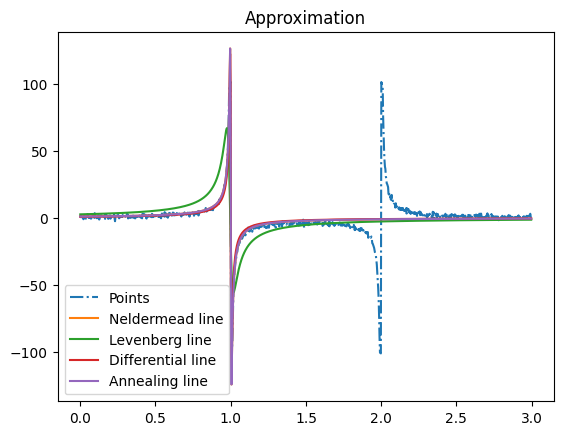

In [24]:
plt.plot(x_points, values, '-.', label='Points')
for algo in results:
    plt.plot(
    x_points,
    [rational(
        x,
        results[algo].x[0],
        results[algo].x[1],
        results[algo].x[2],
        results[algo].x[3]
    ) for x in x_points],
    label=f"{algo} line"
)
plt.title("Approximation")
plt.legend()
plt.savefig('./figures/result_approximation.png')
plt.show()

In [35]:
pd.DataFrame(
    columns=['iterations', 'calculations', 'loss', 'a', 'b', 'c', 'd'],
    index=results.keys(),
    data=np.array([
        [results[result].nit if results[result].success else 1000 for result in results],
        [results[result].nfev for result in results],
        [results[result].fun for result in results],
        [results[result].x[0] for result in results],
        [results[result].x[1] for result in results],
        [results[result].x[2] for result in results],
        [results[result].x[3] for result in results],
    ], dtype=object).T
)

,iterations,calculations,loss,a,b,c,d
Neldermead,416,712,135736.724987,-1.002793,1.003289,-2.00092,1.000936
Levenberg,1000,1000,[222220.01402055746],-2.645533,2.636815,-1.989283,0.989785
Differential,4,1135,137285.603494,-0.848279,0.848693,-2.000914,1.000926
Annealing,1000,9246,135736.728494,-1.002623,1.003118,-2.000921,1.000937


# TSP

## Data

In [112]:
dist_table = pd.read_csv('city_dist.txt', sep=';', nrows=20)
dist_table.shape

(20, 2)

In [113]:
from tqdm.notebook import tqdm

data = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(dist_table.values))


In [116]:
import math

def ts_problem(data, max_temperature = 10000):

    path = np.arange(1, data.shape[0], 1)
    np.random.shuffle(path)

    best_solution_dist = math.inf
    current_dist = math.inf
    old_path = path.copy()

    temperature = np.arange(0.00001, max_temperature, 0.0005)[::-1]

    for iter in tqdm(temperature):
        mask = np.random.randint(low=0, high=data.shape[0] - 1, size=2)
        path[mask[0]], path[mask[1]] = path[mask[1]], path[mask[0]]

        for idx, value in enumerate(path):
            if idx == 0:
                current_dist = data[0, value]
            else:
                current_dist += data[path[idx - 1], value]

        current_dist += data[value, 0]

        if iter == temperature[0]:
            first_iter = path.copy()
            first_dist = current_dist

        if (current_dist < best_solution_dist) \
                or ((current_dist > best_solution_dist) 
                and (math.exp(-1 * (current_dist - best_solution_dist) / iter) > np.random.rand())):
            best_solution_dist = current_dist
            old_path = path.copy()
        else:
            path = old_path.copy()

    first_iter = np.append(0, first_iter)
    first_iter = np.append(first_iter, 0)

    old_path = np.append(0, old_path)
    old_path = np.append(old_path, 0)
    return {
        'fist_path': first_iter, 
        'first_dist': first_dist, 
        'result_path': old_path, 
        'result_dist': current_dist
    }

In [117]:
results = ts_problem(data)

  0%|          | 0/20000000 [00:00<?, ?it/s]

In [118]:
results

{'fist_path': array([ 0,  3, 14, 10, 12,  8, 19, 15,  7,  6,  1, 18, 16, 13,  4,  5, 17,
        11,  2,  9,  0]),
 'first_dist': 2024.2538003659486,
 'result_path': array([ 0, 17, 18, 10, 12,  4, 19,  7, 13,  9,  8,  3,  1,  2,  5, 16, 15,
        11,  6, 14,  0]),
 'result_dist': 817.9505785039942}

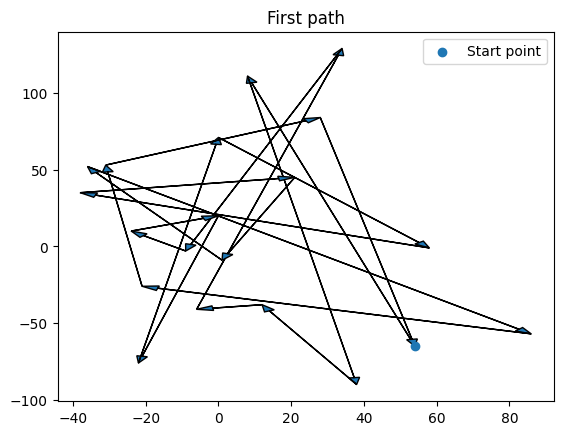

In [119]:
plt.title("First path")
for index, point in enumerate(results['fist_path'][:-1]):
    plt.arrow(
        dist_table.values[point, 0], dist_table.values[point, 1],
        dist_table.values[results['fist_path'][index + 1] , 0] - dist_table.values[point, 0],
        dist_table.values[results['fist_path'][index + 1] , 1] - dist_table.values[point, 1],
        head_width= 3, length_includes_head=True
    )
plt.scatter(dist_table.values[0, 0], dist_table.values[0, 1], label='Start point')
plt.legend()
plt.savefig('./figures/first_path.png')
plt.show()

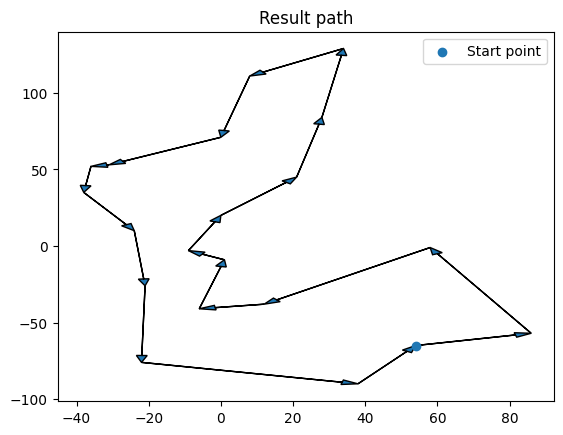

In [120]:
plt.title("Result path")
for index, point in enumerate(results['result_path'][:-1]):
    plt.arrow(
        dist_table.values[point, 0], dist_table.values[point, 1],
        dist_table.values[results['result_path'][index + 1] , 0] - dist_table.values[point, 0],
        dist_table.values[results['result_path'][index + 1] , 1] - dist_table.values[point, 1],
        head_width= 3, length_includes_head=True
    )
plt.scatter(dist_table.values[0, 0], dist_table.values[0, 1], label='Start point')
plt.legend()
plt.savefig('./figures/result_path.png')
plt.show()